### Let's demonstrate the image formation pipeline in ``cryojax``.

In [53]:
# Jax imports
import equinox as eqx
import jax
import jax.numpy as jnp
import numpy as np
from jax import config

config.update("jax_enable_x64", False)

In [2]:
# Plotting imports and function definitions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
def plot_image(image, fig, ax, cmap="gray", label=None, **kwargs):
    im = ax.imshow(image, cmap=cmap, origin="lower", **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    if label is not None:
        ax.set(title=label)
    return fig, ax

In [4]:
# Image simulator imports
import cryojax.simulator as cs
from cryojax.utils import fftn, irfftn, make_frequencies

In [5]:
# Volume filename and metadata
filename = "../tests/data/3jar_13pf_bfm1_ps5_28.mrc"

First we must read in our template into a given volume representation of the ``Specimen``. We also must choose its ``Pose``.

In [6]:
# Read template into either an ElectronCloud or ElectronGrid
resolution = 5.28  # Angstroms
# density = cs.VoxelCloud.from_file(filename, config=dict(atol=1e-8))
density = cs.VoxelGrid.from_file(filename, config=dict(pad_scale=1.5))
pose = cs.EulerPose(
    offset_x=-50.0, offset_y=20.0, view_phi=-20, view_theta=100, view_psi=20
)
specimen = cs.Specimen(density=density, pose=pose, resolution=resolution)

Next we have to choose a scattering (or in this case, projection) method. This will depend on the ``Specimen`` representation.

In [7]:
# Configure the image formation process
shape = (81, 82)
pad_scale = 1.5
# scattering = cs.NufftScattering(shape=shape, pad_scale=pad_scale, eps=1e-5)
scattering = cs.FourierSliceScattering(shape=shape, pad_scale=pad_scale)

Now, it's time to configure the imaging instrument. This, at minimum, requires an ``Optics`` model. Here, we also include models of the ``Exposure`` to the electron beam, and the ``Detector``. For example, by default the optics model is ``NullOptics``. Here, we configure multiple instruments to demonstrate different stages of the image formation pipeline.

In [8]:
# Initialize the instrument
optics = cs.CTFOptics(
    defocus_u=10000, defocus_v=10000, amplitude_contrast=0.07
)
exposure = cs.UniformExposure(N=1e5, mu=0.0)
detector = cs.GaussianDetector(
    pixel_size=resolution,
    key=jax.random.PRNGKey(seed=1234),
    variance=cs.Constant(1.0),
)
instrument_s = cs.Instrument(exposure=exposure)
instrument_o = cs.Instrument(exposure=exposure, optics=optics)
instrument_d = cs.Instrument(
    exposure=exposure, optics=optics, detector=detector
)

Now, choose a model for the solvent. By default, this is just ``NullIce``. Here, we model the ice as gaussian colored noise with ``GaussianIce``.

In [9]:
# Then, choose a model for the solvent
solvent = cs.GaussianIce(
    key=jax.random.PRNGKey(seed=0), variance=cs.Exp(amplitude=1.0, scale=1.0)
)

Finally, we can initialize our imaging model.

In [10]:
# Image formation models
scattering_model = cs.ImagePipeline(
    scattering=scattering,
    specimen=specimen,
    instrument=instrument_s,
    solvent=solvent,
)
optics_model = cs.ImagePipeline(
    scattering=scattering,
    specimen=specimen,
    instrument=instrument_o,
    solvent=solvent,
)
detector_model = cs.ImagePipeline(
    scattering=scattering,
    specimen=specimen,
    instrument=instrument_d,
    solvent=solvent,
)

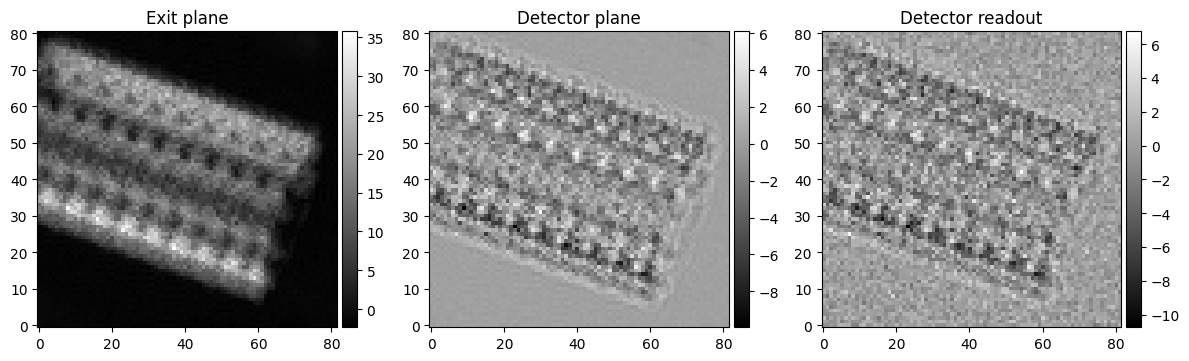

In [11]:
# Plot models
fig, axes = plt.subplots(ncols=3, figsize=(12, 6))
ax1, ax2, ax3 = axes
im1 = plot_image(scattering_model(), fig, ax1, label="Exit plane")
im2 = plot_image(optics_model(), fig, ax2, label="Detector plane")
im3 = plot_image(detector_model(), fig, ax3, label="Detector readout")
plt.tight_layout()

Models can also include ``Filter``s. The following is a demonstration of a ``WhiteningFilter`` and a ``LowpassFilter``. These are precomputed upon initialization and applied automatically in the image formation pipeline. 

To compute a ``WhiteningFilter``, we first have to generate some synthetic data of structured noise from which we may compute its power spectrum.

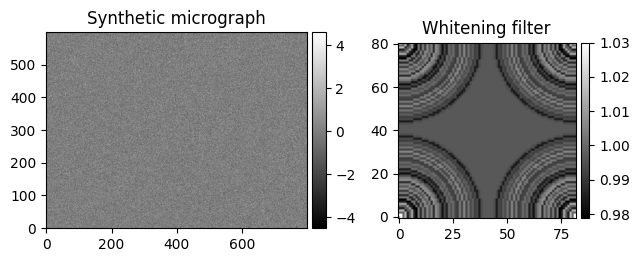

In [12]:
# Instantiate image filters
fig, axes = plt.subplot_mosaic(
    """
AAAABBB
""",
    figsize=(6.5, 3.5),
)
freqs = make_frequencies((800, 600), pixel_size=resolution)
micrograph = solvent.sample(freqs) * optics(freqs) + fftn(
    detector.sample(freqs)
)
whiten = cs.WhiteningFilter(scattering.shape, micrograph=micrograph)
plot_image(irfftn(micrograph.T), fig, axes["A"], label="Synthetic micrograph")
plot_image(whiten.filter, fig, axes["B"], label="Whitening filter")
plt.tight_layout()

Now generate an image with the toy icy structured noise model with a given whitening filter. We will also apply a low pass filter for antialiasing.

(<Figure size 350x350 with 2 Axes>, <AxesSubplot: >)

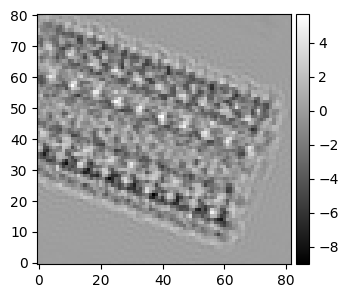

In [13]:
# Show forward model for a whitened image
fig, ax = plt.subplots(figsize=(3.5, 3.5))
filters = [
    cs.LowpassFilter(scattering.padded_shape, cutoff=0.95),
    cs.WhiteningFilter(scattering.padded_shape, micrograph=micrograph),
]
filtered_model = cs.ImagePipeline(
    scattering=scattering,
    specimen=specimen,
    instrument=instrument_d,
    filters=filters,
)
plot_image(filtered_model.render(), fig, ax)

If we want to solve the inverse problem and find the model parameters that most likely generated the data, we want to define a function that can be arbitrarily transformed by JAX and evaulated at subsets of the parameters.

In [14]:
def update_model(
    pixel_size: jax.Array, model: cs.GaussianImage
) -> cs.GaussianImage:
    return eqx.tree_at(
        lambda m: m.instrument.detector.pixel_size, model, pixel_size
    )


@jax.jit
def compute_image(pixel_size: jax.Array, model: cs.GaussianImage) -> jax.Array:
    model = update_model(pixel_size, model)
    return model()

(<Figure size 800x600 with 4 Axes>, <AxesSubplot: >)

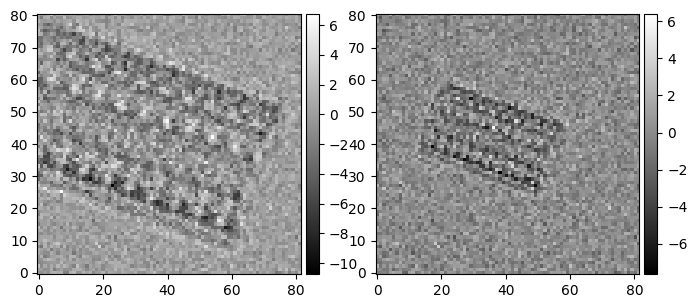

In [15]:
# Plot jitted model with updated parameters.
fig, axes = plt.subplots(ncols=2, figsize=(8, 6))
ax1, ax2 = axes
plot_image(compute_image(detector.pixel_size, detector_model), fig, ax1)
plot_image(compute_image(2 * detector.pixel_size, detector_model), fig, ax2)

Now, we can also use the model to compute a likelihood. For this, we can use the ``GaussianImage`` model. This is a subclass of the ``ImagePipeline``, adding the ability to evaulate a likelihood. Let's evaulate the likelihood at the simulated data, and visualize the residuals.

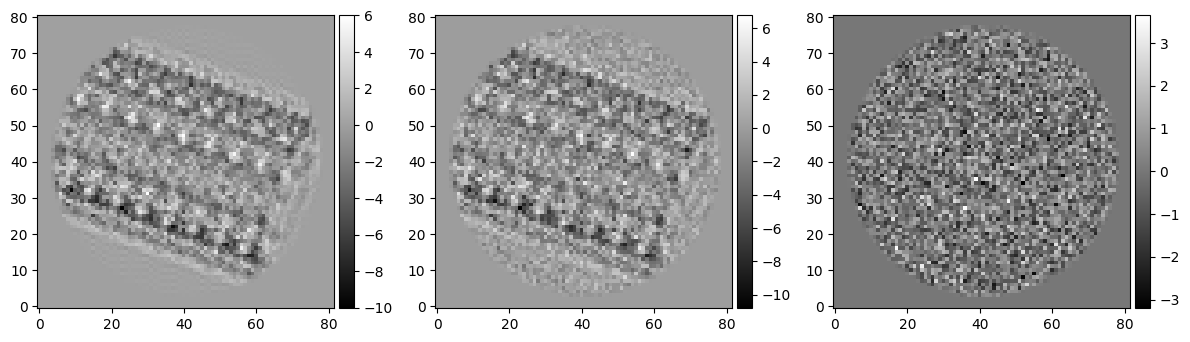

In [16]:
# Initialize the model and plot residuals
fig, axes = plt.subplots(ncols=3, figsize=(12, 6))
ax1, ax2, ax3 = axes
mask = cs.CircularMask(scattering.shape)
masks = [mask]
observation_model = cs.GaussianImage(
    scattering=scattering, specimen=specimen, instrument=instrument_d
)
observed = mask(observation_model())
model = cs.GaussianImage(
    scattering=scattering,
    specimen=specimen,
    instrument=instrument_d,
    masks=masks,
)
simulated, observed = model.render(), observed
plot_image(simulated, fig, ax1)
plot_image(observed, fig, ax2)
plot_image(simulated - observed, fig, ax3)
plt.tight_layout()

Evaluating the ``GaussianImage`` with the observed data set will automatically evaulate the ``GausianImage.log_likelihood`` function.

In [44]:
def update_model(pixel_size: jax.Array, model: cs.GaussianImage) -> cs.GaussianImage:
    return eqx.tree_at(lambda m: m.instrument.detector.pixel_size, model, pixel_size)

A = array[0, 0]
B = eqx.tree_at(lambda array: array[0], A, 2.0)
>>> B = [2, 0]

@jax.jit
def compute_loss(pixel_size: jax.Array, model: cs.GaussianImage, observed: jax.Array) -> jax.Array:
    model = update_model(pixel_size, model)
    return model(observed)

@jax.jit
@jax.grad
def compute_grad(pixel_size: jax.Array, model: cs.GaussianImage, observed: jax.Array) -> jax.Array:
    return compute_loss(pixel_size, model, observed)

In [ ]:
# use tqdm for a progress bar and update a value
from tqdm import tqdm
from jax import value_and_grad
from jax.experimental import optimizers
from jax.tree_util import tree_map

with tqdm(total=100) as pbar:

    def loss(params):
        return compute_loss(params, model, observed)

    opt_init, opt_update, get_params = optimizers.adam(step_size=1e-2)
    opt_state = opt_init(detector.pixel_size)
    for i in range(100):
        value, grads = value_and_grad(loss)(get_params(opt_state))
        opt_state = opt_update(i, grads, opt_state)
        pbar.update(1)
        pbar.set_description(f"Loss: {value:.3f}")

In [ ]:
for i in range(1000):
    if i % 100 == 0:
        print(f"Loss: {loss(detector.pixel_size, model, observed):.3f}")

In [52]:
model(observed)

Array(0.63677186, dtype=float32)

In [45]:
# Benchmark loss pipeline
%timeit likelihood = compute_loss(detector.pixel_size+.01, model, observed)

6.38 ms ± 619 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
observed.shape

observed_stack = jnp.stack([observed, observed, observed], axis=0)
pixel_sizes = jnp.stack(
    [
        detector.pixel_size + 0.01,
        detector.pixel_size + 0.02,
        detector.pixel_size + 0.03,
    ],
    axis=0,
)

In [46]:
comp_loss_vmap = jax.vmap(compute_loss, in_axes=(0, None, 0))

In [50]:
%timeit comp_loss_vmap(pixel_sizes, model, observed_stack)

9.81 ms ± 130 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
# Benchmark gradient pipeline
%timeit grad = compute_grad(detector.pixel_size+.01, model, observed)